# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

1. The main limitation of one-hot vectors is Sparsity and ir treat every word as equally unrelated.

2. Meaning emerges from co-occurrence patterns means words used in similar contexts end up with similar vectors.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [5]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [7]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajays\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajays\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [8]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))  # YOUR CODE HERE
documents = data.data  # YOUR CODE HERE

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [9]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower())  # YOUR CODE HERE
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # YOUR CODE HERE (filter step)
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

1. We remove stopwrods to reduce noise and focus learning on content bearing words.
2. Removing them is a bad idea when function words carry meaning (eg sentiment/negation like "not", or authorship/stylistic signals).

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [10]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [11]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

# YOUR CODE HERE
w2v.wv["car"][:10]

array([-0.90926397,  1.159697  ,  0.66478485, -0.35344714,  0.00858668,
       -0.9001314 ,  0.3617567 ,  1.390696  , -0.9557    , -0.7639389 ],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [12]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=30):
    print(f'{word:15s} : {score:3f}')


# YOUR CODE HERE - iterate through the results and print each word and score

Most similar words to 'computer':
network         : 0.945616
systems         : 0.916866
commercial      : 0.898698
digital         : 0.895187
products        : 0.893066
project         : 0.888186
voice           : 0.881723
software        : 0.879878
currently       : 0.873857
computers       : 0.871531
bbs             : 0.868684
electronic      : 0.862725
users           : 0.858830
design          : 0.851476
includes        : 0.850446
technology      : 0.850007
registration    : 0.848573
engineering     : 0.848441
service         : 0.844689
development     : 0.843514
access          : 0.843390
additional      : 0.843186
companies       : 0.841198
capabilities    : 0.840354
networks        : 0.838888
export          : 0.838706
remote          : 0.838093
mainframe       : 0.836097
equipment       : 0.834125
management      : 0.833566


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

1. The nearest neighbors for computer usually reflect mostly topic similarity, sometimes mixed with functional similarity.
2. 

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [13]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
w2v.wv.most_similar(
    positive=['king', 'woman'],
    negative=['man'],
    topn=20
)

[('savagely', 0.9696977138519287),
 ('slaughtered', 0.9618241786956787),
 ('fleeing', 0.9595695734024048),
 ('bears', 0.9588884711265564),
 ('eastern', 0.956122100353241),
 ('agdam', 0.9546986818313599),
 ('shostack', 0.9542818665504456),
 ('weaver', 0.9541596174240112),
 ('lenin', 0.9529090523719788),
 ('azerbadjan', 0.9518402814865112),
 ('anatolia', 0.951659619808197),
 ('village', 0.9512597322463989),
 ('served', 0.9503478407859802),
 ('lake', 0.9502660632133484),
 ('adam', 0.95011305809021),
 ('azeri', 0.9495853185653687),
 ('girls', 0.9495486617088318),
 ('joseph', 0.9495049118995667),
 ('retreat', 0.94905686378479),
 ('guberniia', 0.9485239386558533)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [14]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [15]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv['king'] - w2v.wv['man'] + w2v.wv['woman']
queen_vec = w2v.wv['queen']

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.7797


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

1. Analogies can be wrong even with good embeddings because vector offsets don’t always represent clean relationships and results are sensitive to corpus bias/frequency.
2. Analogy scores may not correlate with real tasks because downstream performance depends on domain, labels, and objectives (not just geometric neatness).

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

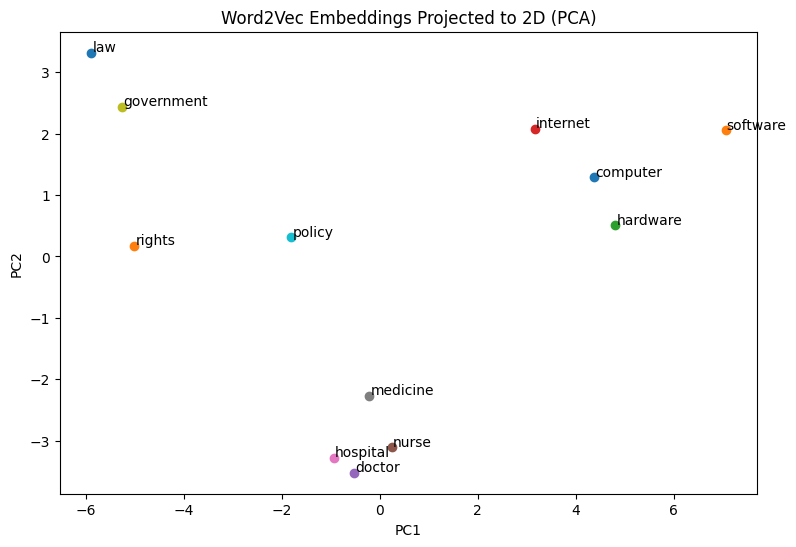

In [16]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])  # YOUR CODE HERE

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)  # YOUR CODE HERE

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

1. In my plot, hospital, doctor, nurse and medicine are closet together, where are internet, computer, hardware and software are together, and law, government, right, policy are close together.
2. I don't see the clusters between health, tech and politics because they don't share the similar context.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [17]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [19]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# # FastText neighbors
print("FastText neighbors for:", query)
for word, score in ft.wv.most_similar(query, topn=10):
    print(f'{word:15s} : {score:3f}')

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    for word, score in w2v.wv.most_similar(query, topn=10):
        print(f'{word:15s} : {score:3f}')
    
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes        : 0.972396
compact         : 0.961642
comics          : 0.961011
compute         : 0.958045
items           : 0.949269
subsystems      : 0.945871
competitors     : 0.944908
compuadd        : 0.944640
techniques      : 0.941423
company         : 0.939628

Word2Vec neighbors for: computers
products        : 0.972636
additional      : 0.971226
bbs             : 0.964201
ocr             : 0.962724
currently       : 0.960367
crypt           : 0.960062
shareware       : 0.959636
packages        : 0.959104
turbocom        : 0.958172
items           : 0.957744


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [20]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    if word not in model.wv:
        return None
    return model.wv.most_similar(word, topn=topn)
    
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  ventura         0.992
  paris           0.991
  barbara         0.991
  pa              0.990
  hill            0.990
  princeton       0.989
  pennsylvania    0.989
  forbes          0.988

Query: space
  nasa            0.885
  shuttle         0.880
  launch          0.861
  station         0.832
  commercial      0.789
  flight          0.788
  research        0.783
  center          0.781

Query: religion
  religious       0.984
  islam           0.981
  christian       0.978
  christians      0.975
  religions       0.973
  christianity    0.972
  belief          0.971
  evidence        0.971

Query: graphics
  programming     0.981
  unix            0.970
  ibm             0.962
  postscript      0.961
  workstations    0.961
  mpeg            0.961
  manual          0.961
  borland         0.960


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

1. Neighbors can help search by expanding queries with semantically related terms.
2. Deploying directly can go wrong via bias amplification, irrelevant expansions (false positives), domain drift, and problematic/unsafe associations.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, or None if OOV."""
    if word not in model.wv:
        return None
    return model.wv.most_similar(word, topn=topn)

def neighbors_df(model, query, topn=10, label="model"):
    """Return a neat DataFrame of neighbors."""
    result = semantic_neighbors(model, query, topn=topn)
    if result is None:
        return pd.DataFrame({"model":[label], "query":[query], "neighbor":["(OOV)"], "score":[None]})
    return pd.DataFrame({
        "model": [label]*len(result),
        "query": [query]*len(result),
        "neighbor": [w for w,_ in result],
        "score": [s for _,s in result]
    })

def train_w2v(sentences, vector_size=100, window=5, sg=1, min_count=5, workers=4, seed=42):
    """Train Word2Vec with specified params."""
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg,
        seed=seed
    )
    return model



### neighbors_df(model, query, topn, label):
This converts the neighbor results into a clean DataFrame with columns: model name, query, neighbor, score.

If the word is not in vocab, it returns a one-row table saying (OOV) instead of failing.

The label helps you compare multiple models side-by-side.

### train_w2v(sentences, vector_size, window, sg, ...)
This is a reusable trainer that builds a Word2Vec model using parameters you specify.

vector_size controls the embedding dimension (how much “space” the model has to store meaning).

window controls how far the model looks around a word to learn context.

sg=1 means Skip-gram, sg=0 means CBOW.

In [22]:
query_word = "religion"
topn = 10


You set one query word (like "religion") and reuse it for all experiments.

This makes your comparisons fair because only one parameter changes at a time.

topn is the number of neighbors you want to show (like top 10 similar words).

In [23]:
w2v_w2 = train_w2v(corpus, vector_size=100, window=2, sg=1)
w2v_w10 = train_w2v(corpus, vector_size=100, window=10, sg=1)

df = pd.concat([
    neighbors_df(w2v_w2, query_word, topn=topn, label="Skip-gram window=2"),
    neighbors_df(w2v_w10, query_word, topn=topn, label="Skip-gram window=10"),
], ignore_index=True)

df


,model,query,neighbor,score
0,Skip-gram window=2,religion,religions,0.923043
1,Skip-gram window=2,religion,doctrine,0.920998
2,Skip-gram window=2,religion,christianity,0.918216
3,Skip-gram window=2,religion,doctrines,0.918077
4,Skip-gram window=2,religion,mormon,0.917247
5,Skip-gram window=2,religion,teachings,0.914945
6,Skip-gram window=2,religion,beings,0.911539
7,Skip-gram window=2,religion,teaching,0.910580
8,Skip-gram window=2,religion,scholars,0.908908
9,Skip-gram window=2,religion,believers,0.907296


You train two models with the same settings except window size.

window=2 learns from very local context → often tighter, phrase-like associations.

window=10 learns from wider context → often more topic/semantic associations.

Then you combine both results into one table to compare.

In [24]:
w2v_v50 = train_w2v(corpus, vector_size=50, window=5, sg=1)
w2v_v200 = train_w2v(corpus, vector_size=200, window=5, sg=1)

df = pd.concat([
    neighbors_df(w2v_v50, query_word, topn=topn, label="Skip-gram vec=50"),
    neighbors_df(w2v_v200, query_word, topn=topn, label="Skip-gram vec=200"),
], ignore_index=True)

df


,model,query,neighbor,score
0,Skip-gram vec=50,religion,religious,0.873017
1,Skip-gram vec=50,religion,christian,0.867348
2,Skip-gram vec=50,religion,judaism,0.862252
3,Skip-gram vec=50,religion,religions,0.859832
4,Skip-gram vec=50,religion,viewpoint,0.859271
5,Skip-gram vec=50,religion,intellectual,0.857289
6,Skip-gram vec=50,religion,doctrines,0.855128
7,Skip-gram vec=50,religion,beings,0.854976
8,Skip-gram vec=50,religion,christianity,0.853984
9,Skip-gram vec=50,religion,mormons,0.851520


You train two models with the same settings except vector dimension.

Smaller vectors (50) can be faster but may lose detail → neighbors can look noisier.

Larger vectors (200) can capture richer meaning → but needs enough data to avoid overfitting.

The output table shows how the neighborhood changes

In [25]:
w2v_cbow = train_w2v(corpus, vector_size=100, window=5, sg=0)
w2v_sg   = train_w2v(corpus, vector_size=100, window=5, sg=1)

df = pd.concat([
    neighbors_df(w2v_cbow, query_word, topn=topn, label="CBOW (sg=0)"),
    neighbors_df(w2v_sg, query_word, topn=topn, label="Skip-gram (sg=1)"),
], ignore_index=True)

df


,model,query,neighbor,score
0,CBOW (sg=0),religion,religious,0.984856
1,CBOW (sg=0),religion,christian,0.981997
2,CBOW (sg=0),religion,evidence,0.977756
3,CBOW (sg=0),religion,religions,0.974748
4,CBOW (sg=0),religion,islam,0.974648
5,CBOW (sg=0),religion,christianity,0.974584
6,CBOW (sg=0),religion,christians,0.974409
7,CBOW (sg=0),religion,revelation,0.971767
8,CBOW (sg=0),religion,existence,0.969434
9,CBOW (sg=0),religion,beliefs,0.968612


CBOW is usually smoother and works well for frequent words.

Skip-gram often captures better relationships for rarer words (but may be slower).

You train one model in CBOW mode and one in Skip-gram mode.

CBOW predicts the word from its context → often stable for frequent words.

Skip-gram predicts context from the word → often better for rare words and relationships.

The table helps you see which gives more meaningful neighbors.

In [26]:
# Learn bigram phrases from the corpus
phrases = Phrases(corpus, min_count=5, threshold=10)
bigram = Phraser(phrases)

# Transform corpus into bigram-aware corpus
corpus_bi = [bigram[sent] for sent in corpus]

# Train baseline vs bigram model
w2v_base = train_w2v(corpus, vector_size=100, window=5, sg=1)
w2v_bi   = train_w2v(corpus_bi, vector_size=100, window=5, sg=1)

df = pd.concat([
    neighbors_df(w2v_base, query_word, topn=topn, label="Baseline (no bigrams)"),
    neighbors_df(w2v_bi, query_word, topn=topn, label="With bigrams"),
], ignore_index=True)

df


,model,query,neighbor,score
0,Baseline (no bigrams),religion,religions,0.872665
1,Baseline (no bigrams),religion,judaism,0.855256
2,Baseline (no bigrams),religion,intellectual,0.848207
3,Baseline (no bigrams),religion,religious,0.842927
4,Baseline (no bigrams),religion,christianity,0.836171
5,Baseline (no bigrams),religion,believers,0.830357
6,Baseline (no bigrams),religion,doctrines,0.830113
7,Baseline (no bigrams),religion,beliefs,0.829603
8,Baseline (no bigrams),religion,islam,0.828659
9,Baseline (no bigrams),religion,racist,0.825363


With bigrams, the model treats common two-word expressions as single concepts, which often improves meaning for phrases.

You first learn common two-word phrases from your corpus (Phrases).

Then you transform the corpus so those phrases become single tokens like new_york.

You train a model on the bigram corpus and compare it to the baseline model.

This improves embeddings for multi-word concepts that should act like one meaning unit.

In [27]:
# See examples of learned phrases (may show as "x_y")
examples = [w for w in w2v_bi.wv.index_to_key if "_" in w][:30]
examples


['max_max',
 'x_x',
 'r_g',
 'g_r',
 'would_like',
 'q_q',
 'n_n',
 'united_states',
 'new_york',
 'db_db',
 'anyone_know',
 'thanks_advance',
 'last_year',
 'p_p',
 'something_like',
 'many_people',
 'law_enforcement',
 'clipper_chip',
 'even_though',
 'los_angeles',
 'years_ago',
 'make_sure',
 'looks_like',
 'power_play',
 'w_w',
 'gun_control',
 'max_q',
 'q_p',
 'r_r',
 'hard_drive']